In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

import calendar
import time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [82]:
plt.rcParams["figure.figsize"] = (15, 8)

# sns.set(style='whitegrid', palette="bright")
sns.set_theme()
sns.set(font_scale = 1.25)

FONT_SIZE=14

## Plotting utils 

In [83]:
def plot_prediction(df_train, df_test, true_col, prediction_col, 
                    figsize=(20, 8), enlrgd_since='', title='', loc='best'):
    plt.figure(figsize=figsize)
    plt.plot(df_train[true_col], label='Train', color = 'royalblue')
    plt.plot(df_test[true_col], label='Test', color = 'navy')
    plt.plot(df_train[prediction_col], label='Prediction Train', color = 'red', alpha=0.5)
    plt.plot(df_test[prediction_col], label='Prediction Test',  color = 'maroon', alpha=0.5)
    plt.legend(loc=loc)
    plt.title(title)
    plt.grid(linestyle=':', color='k')

    plt.figure(figsize=figsize);
    plt.plot(df_test.loc[enlrgd_since:, true_col], '-', color='navy', 
            label="true data")
    plt.plot(df_test.loc[enlrgd_since:, prediction_col], '-', color='maroon', 
            label="predictions")
    plt.legend()
    plt.title(title + '\nLast month')
    plt.grid(linestyle=':', color='k')
    plt.show()

## Data Load

In [84]:
sales_train_val = pd.read_csv('./data/m5-forecasting-accuracy/sales_train_validation.csv')

In [85]:
calendar = pd.read_csv('./data/m5-forecasting-accuracy/calendar.csv')

In [86]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [87]:
calendar[['date', 'd']].head()

,date,d
0,2011-01-29,d_1
1,2011-01-30,d_2
2,2011-01-31,d_3
3,2011-02-01,d_4
4,2011-02-02,d_5


## Let's pick particular product to observe

In [88]:
sales_train_val.filter(regex='d_').T.median().argmax()

8412

In [89]:
product_data = sales_train_val[sales_train_val.id == 'FOODS_3_090_CA_3_validation']

In [90]:
product_data = product_data.filter(regex='d_').T.rename(columns={8412: 'FOODS_3_090_cnt'})

In [91]:
product_data = (pd.merge(calendar[['date', 'd']], product_data, 
         left_on='d', right_on = product_data.index, how='left')
     .drop(columns='d'))

In [92]:
product_data['date'] = pd.to_datetime(product_data['date'])
product_data_by_time = product_data.set_index(keys='date')

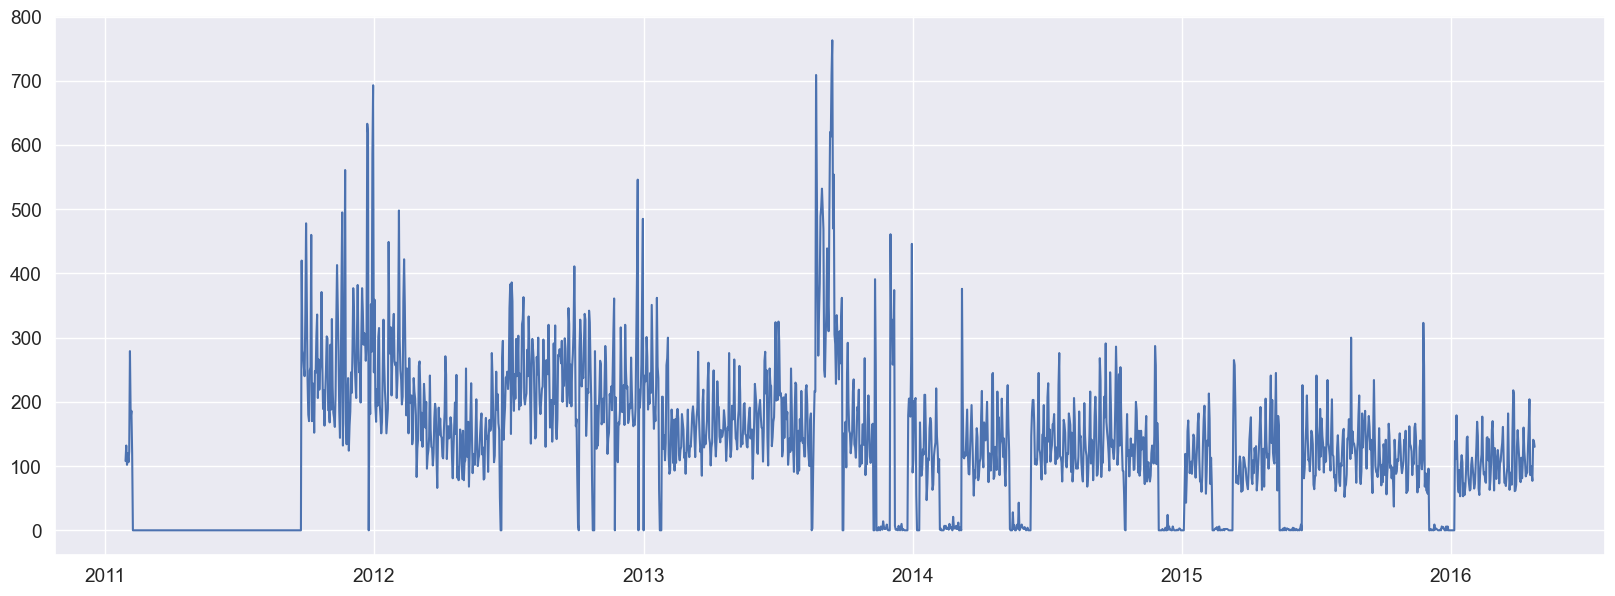

In [93]:
plt.figure(figsize=(20, 7))
plt.plot(product_data_by_time)

In [94]:
product_data_by_time.dropna(inplace=True)

In [95]:
product_data_by_time

,FOODS_3_090_cnt
date,
2011-01-29,108.0
2011-01-30,132.0
2011-01-31,102.0
2011-02-01,120.0
2011-02-02,106.0
...,...
2016-04-20,88.0
2016-04-21,77.0
2016-04-22,141.0


In [96]:
train = product_data_by_time.iloc[:-60]
test = product_data_by_time.iloc[-60:]

## Modelling: ARIMA of seasonal data

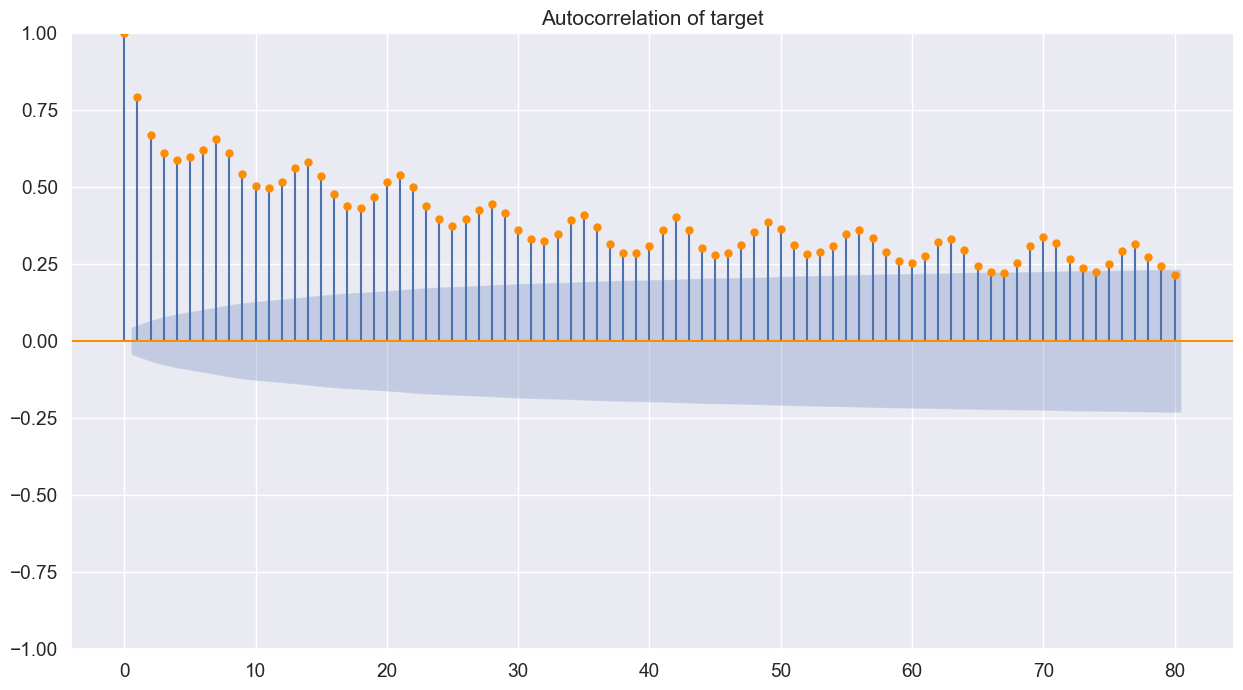

In [97]:
lags = 80

plot_acf(product_data['FOODS_3_090_cnt'].dropna(), lags=lags, color='darkorange', 
         title='Autocorrelation of target');

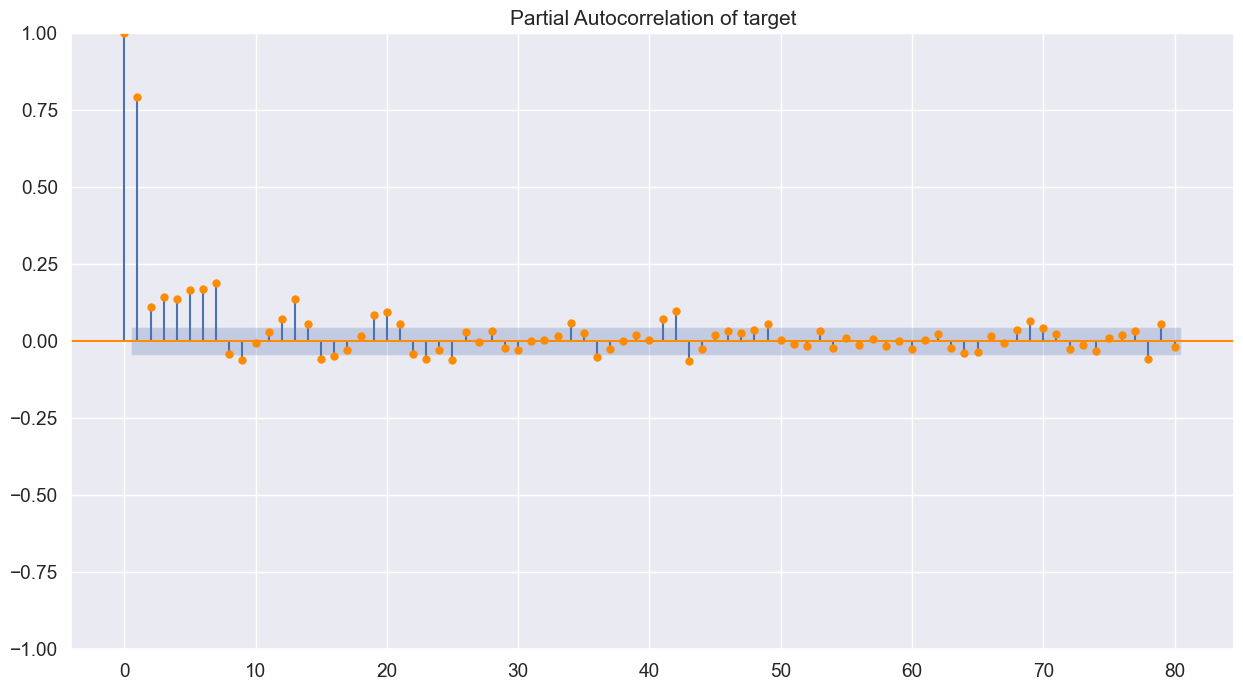

In [98]:
plot_pacf(product_data['FOODS_3_090_cnt'].dropna(), lags=lags, color='darkorange', 
         title='Partial Autocorrelation of target');

In [116]:
arima_model = ARIMA(train['FOODS_3_090_cnt'], order=(7, 0, 7)).fit()

In [117]:
train['prediction'] = arima_model.predict(train.index[0], train.index[-1])
test['prediction'] = arima_model.predict(test.index[0], test.index[-1])

In [118]:
def calculate_mape(actual, forecast):

    # Ensure that the length of actual and forecast lists are equal
    if len(actual) != len(forecast):
        raise ValueError("The length of actual and forecast lists must be the same.")

    # Calculate MAPE
    mape = sum(abs((a - f) / a) for a, f in zip(actual, forecast) if a != 0) / len(actual) * 100
    
    return mape

# Example usage:
# actual = [100, 200, 300, 400, 500]
# forecast = [110, 190, 310, 420, 480]
# print(calculate_mape(actual, forecast))


In [119]:
metrics = {'TRAIN_MAE': round(mean_absolute_error(train['FOODS_3_090_cnt'], train['prediction']), 3),
  'TRAIN_MAPE %': round(calculate_mape(train['FOODS_3_090_cnt'], train['prediction']), 3),
  'TEST_MAE': round(mean_absolute_error(test['FOODS_3_090_cnt'], test['prediction']), 3),\
  'TEST_MAPE %': round(calculate_mape(test['FOODS_3_090_cnt'], test['prediction']), 3)}

arima_metrics_1 = pd.DataFrame(metrics, index=['ARIMA_7_0_7'])

In [120]:
arima_metrics

,TRAIN_MAE,TRAIN_MAPE %,TEST_MAE,TEST_MAPE %
ARIMA trend + seasonality,37.547,100.571,26.864,27.966


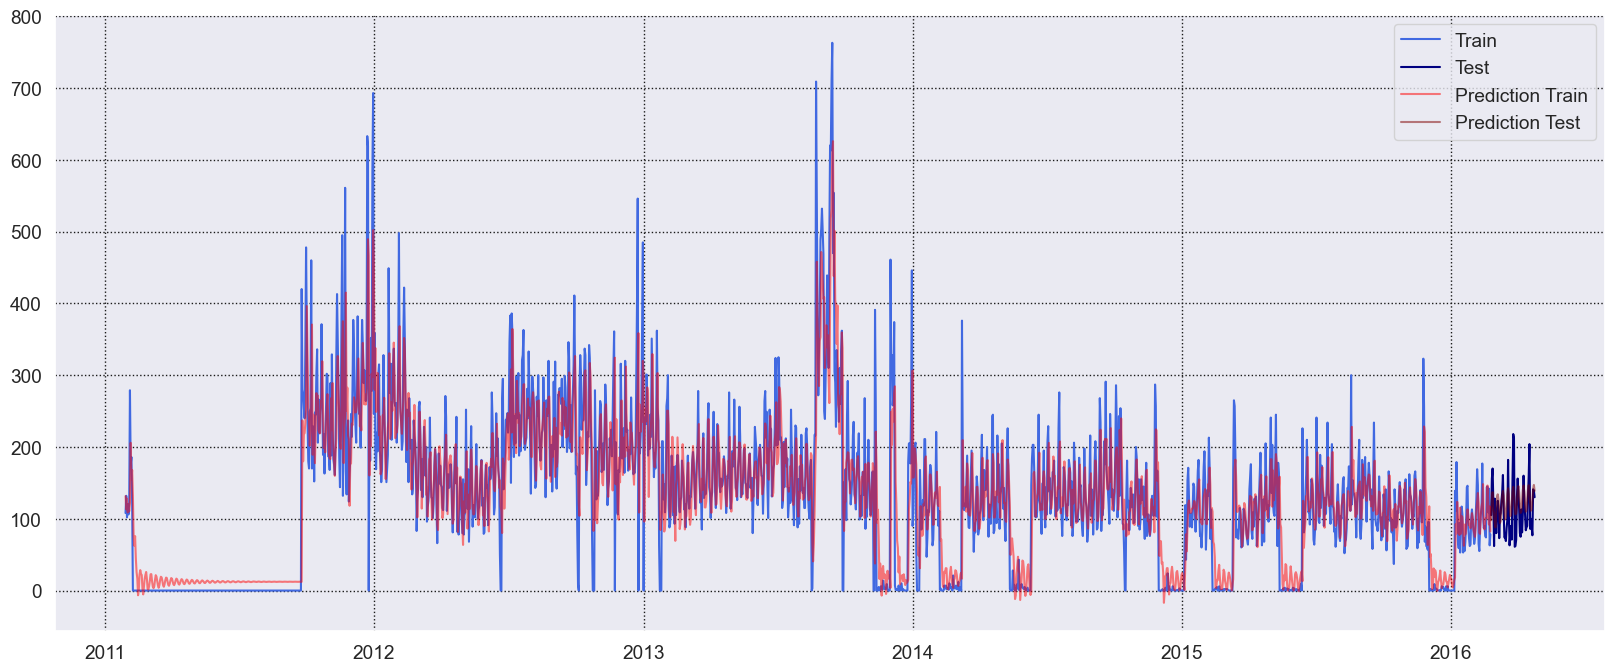

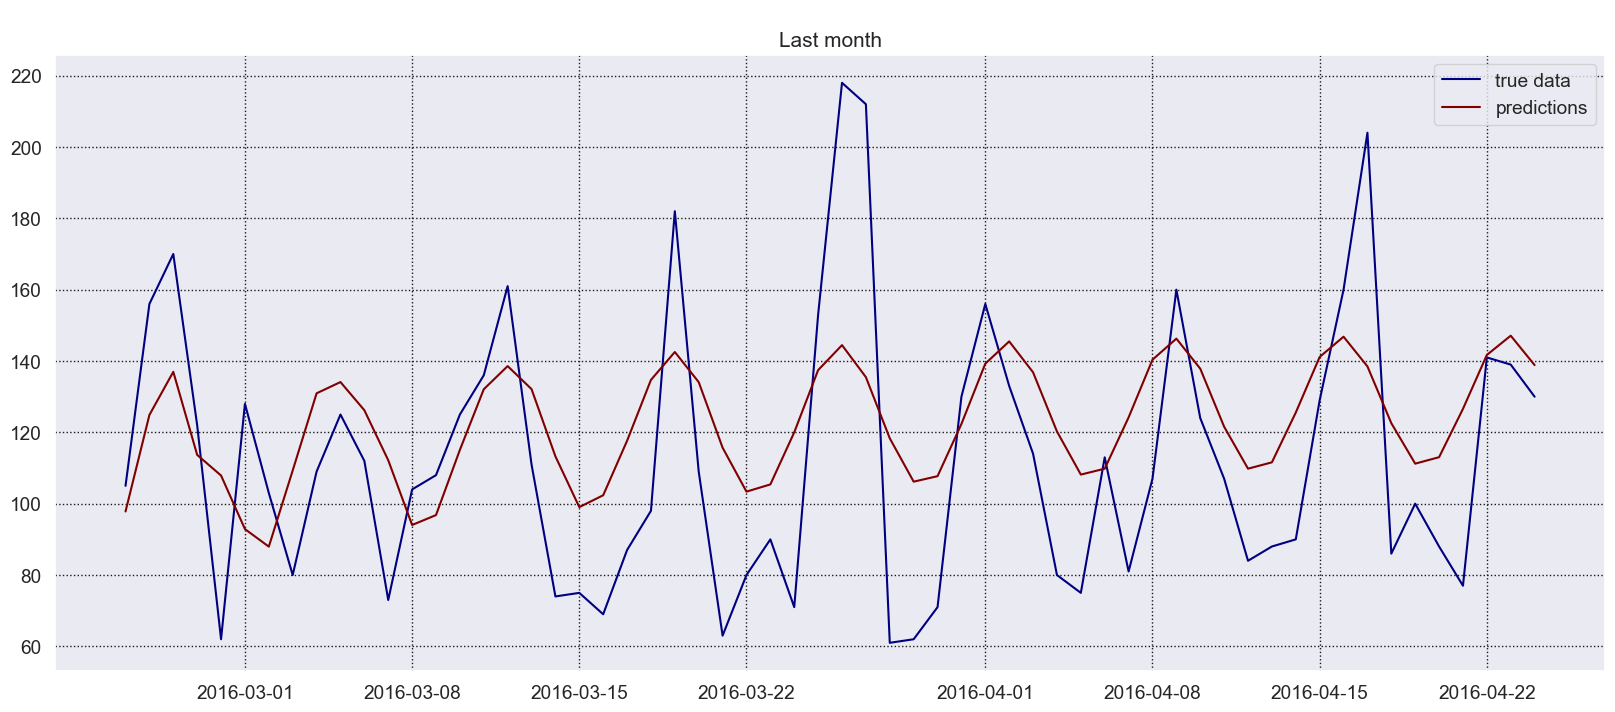

In [65]:
plot_prediction(train, test, true_col='FOODS_3_090_cnt', prediction_col='prediction')

## Product decomposition

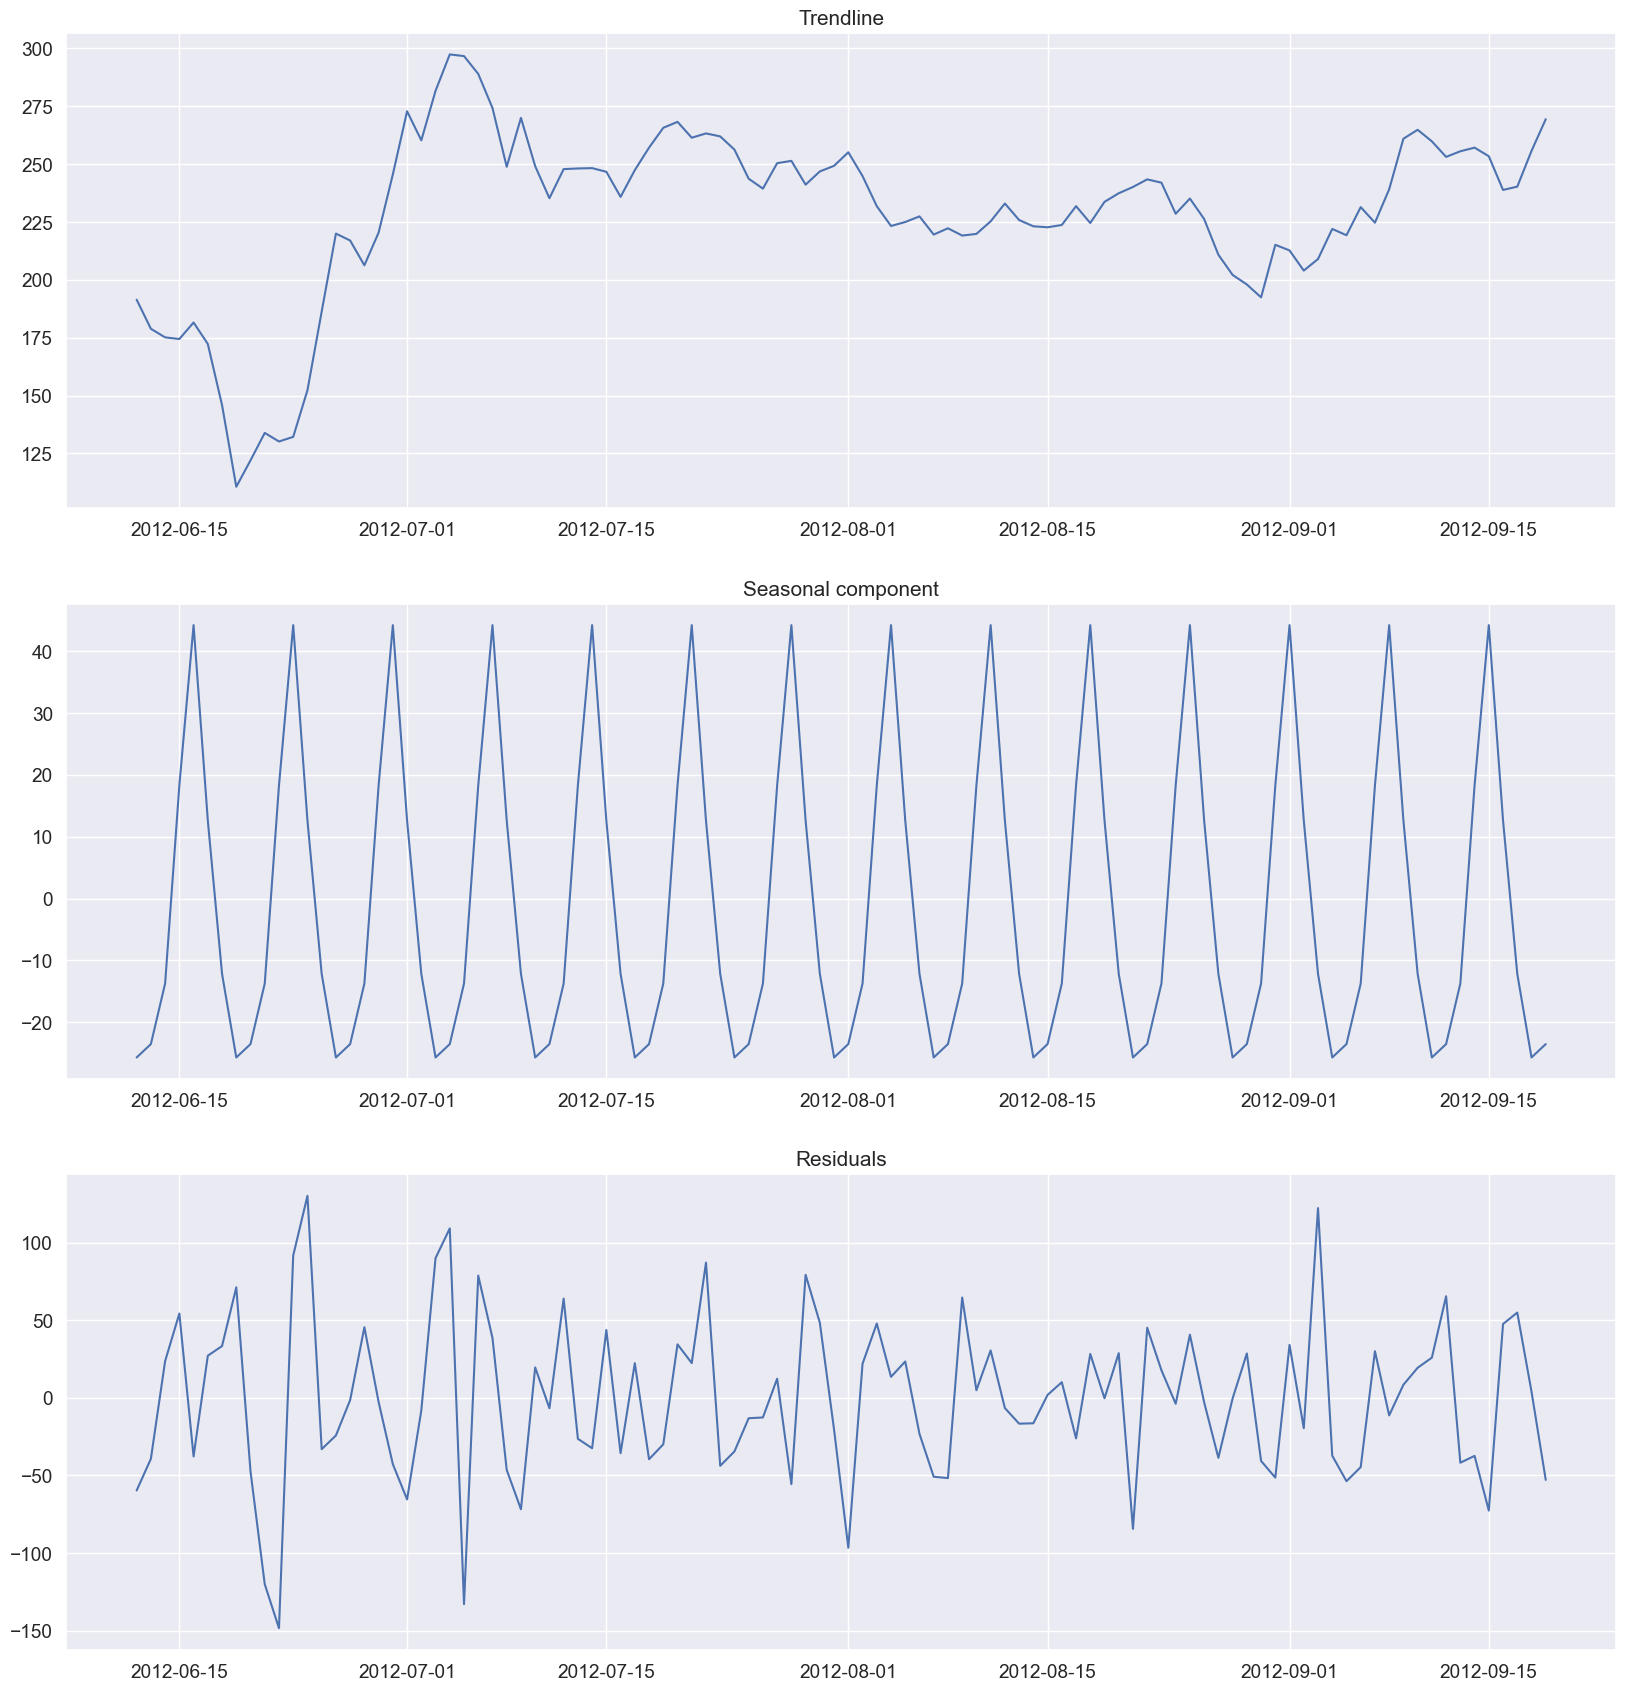

In [164]:
decomposition = seasonal_decompose(train['FOODS_3_090_cnt'], model='additive', period=7)

plt.subplots(3, 1, figsize=(20, 21))

plt.subplot(3, 1, 1)
plt.title('Trendline')
plt.plot(decomposition.trend[500:600])

plt.subplot(3, 1, 2)
plt.title('Seasonal component')
plt.plot(decomposition.seasonal[500:600])

plt.subplot(3, 1, 3)
plt.title('Residuals')
plt.plot(decomposition.resid[500:600])

In [43]:
alpha = 0.001
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(decomposition.trend.diff(1).dropna(), regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
    print("The process is non-stationary.\n")
else:
    print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.01495157968829763
p-value = 0.1
The process is stationary.



C:\Users\oleksii.kachmar\AppData\Local\Temp\ipykernel_21644\939630916.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(decomposition.trend.diff(1).dropna(), regression='c')


## Modelling: ARIMA(TREND) + Seasonality

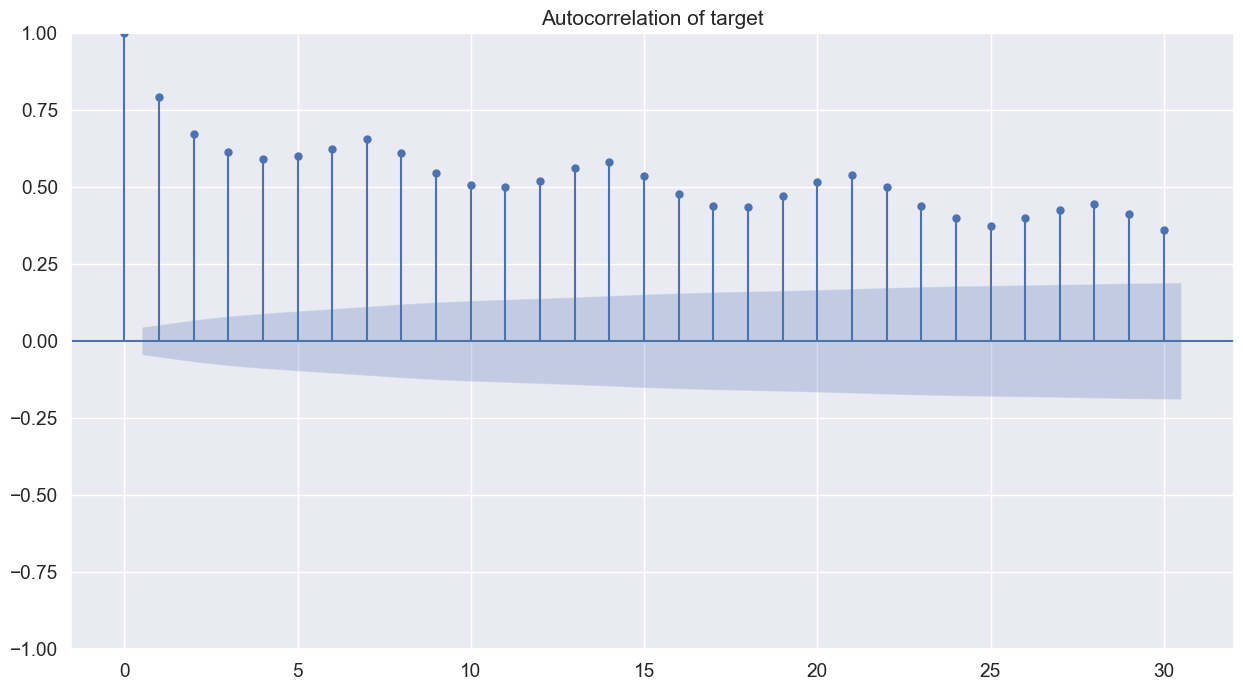

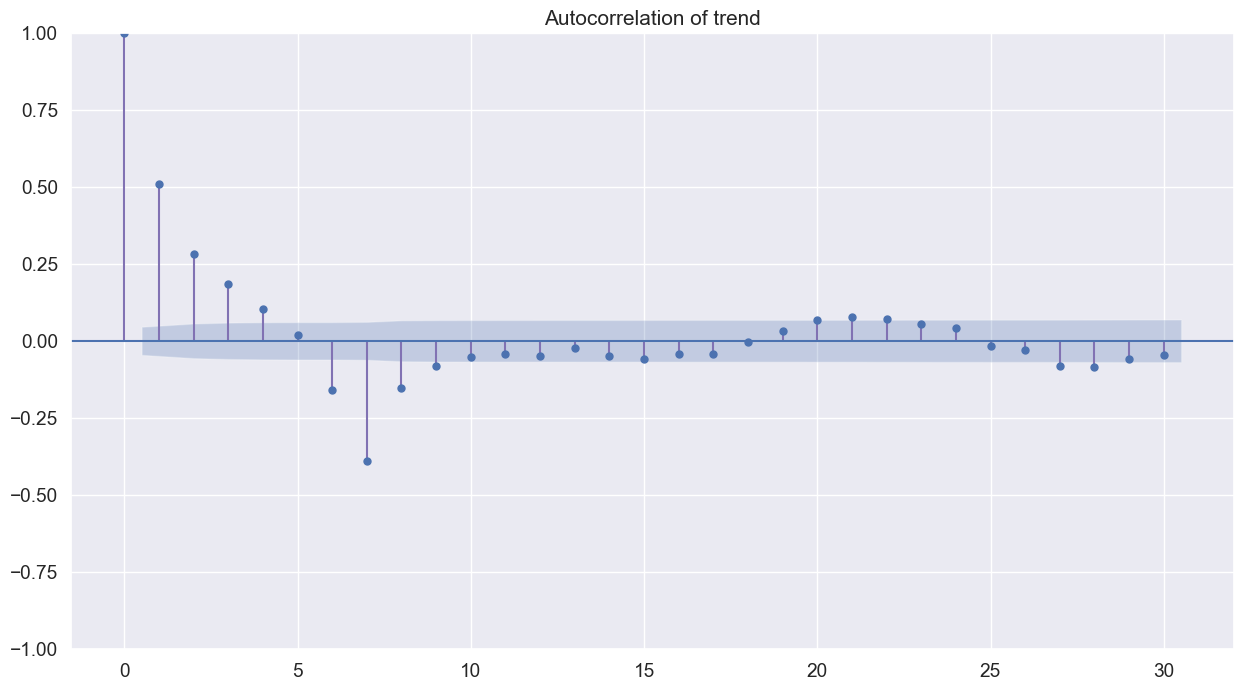

In [67]:
lags = 30

plot_acf(train['FOODS_3_090_cnt'], lags=lags, 
         title='Autocorrelation of target')

plot_acf(decomposition.trend.diff().dropna(), lags=lags, 
         vlines_kwargs={'color' : 'm'},
         title='Autocorrelation of trend')

plt.show()

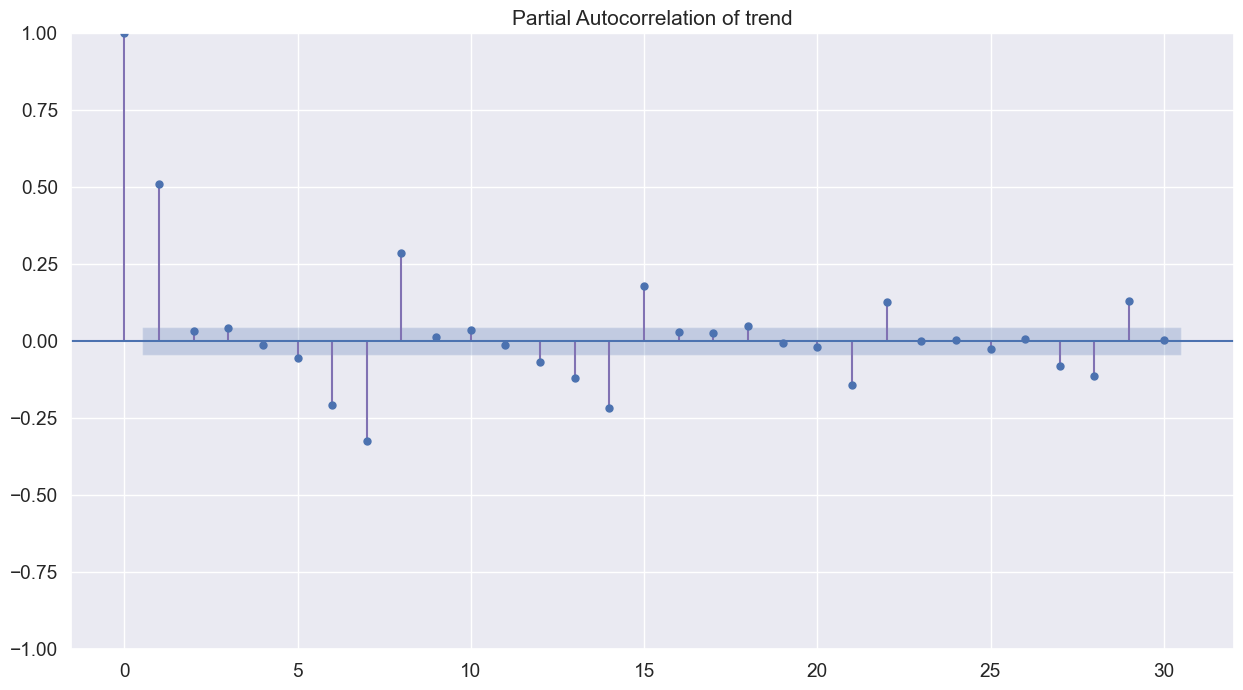

In [68]:
plot_pacf(decomposition.trend.diff().dropna(), lags=lags, 
         vlines_kwargs={'color' : 'm'},
         title='Partial Autocorrelation of trend')


plt.show()

In [129]:
trend_arima_model = ARIMA(decomposition.trend, order=(9, 0, 4)).fit()

In [130]:
train['trend_prediction'] = trend_arima_model.predict(train.index[0], train.index[-1])
test['trend_prediction'] = trend_arima_model.predict(test.index[0], test.index[-1])

In [131]:
(train['trend_seasonal_prediction']) = ((train['trend_prediction'] + decomposition.seasonal)
                                            .apply(lambda val: 0 if val < 0 else val))
(test['trend_seasonal_prediction']) = ((test['trend_prediction'] + decomposition.seasonal.loc['2015-12-24':'2016-02-21'].values)
                                                    .apply(lambda val: 0 if val < 0 else val))

In [132]:
mean_absolute_error(train['FOODS_3_090_cnt'], train['trend_seasonal_prediction']),\
mean_absolute_percentage_error(train['FOODS_3_090_cnt'], train['trend_seasonal_prediction'])

(30.346406106202636, 2.0636399972863504e+16)

In [133]:
mean_absolute_error(test['FOODS_3_090_cnt'], test['trend_seasonal_prediction']),\
mean_absolute_percentage_error(test['FOODS_3_090_cnt'], test['trend_seasonal_prediction'])

(21.831752035222888, 0.21780701749713333)

In [134]:
metrics = {'TRAIN_MAE': round(mean_absolute_error(train['FOODS_3_090_cnt'], train['trend_seasonal_prediction']), 3),
  'TRAIN_MAPE %': round(calculate_mape(train['FOODS_3_090_cnt'], train['trend_seasonal_prediction']), 3),
  'TEST_MAE': round(mean_absolute_error(test['FOODS_3_090_cnt'], test['trend_seasonal_prediction']), 3),\
  'TEST_MAPE %': round(calculate_mape(test['FOODS_3_090_cnt'], test['trend_seasonal_prediction']), 3)}

arima_metrics_2 = pd.DataFrame(metrics, index=['ARIMA trend + seasonality'])

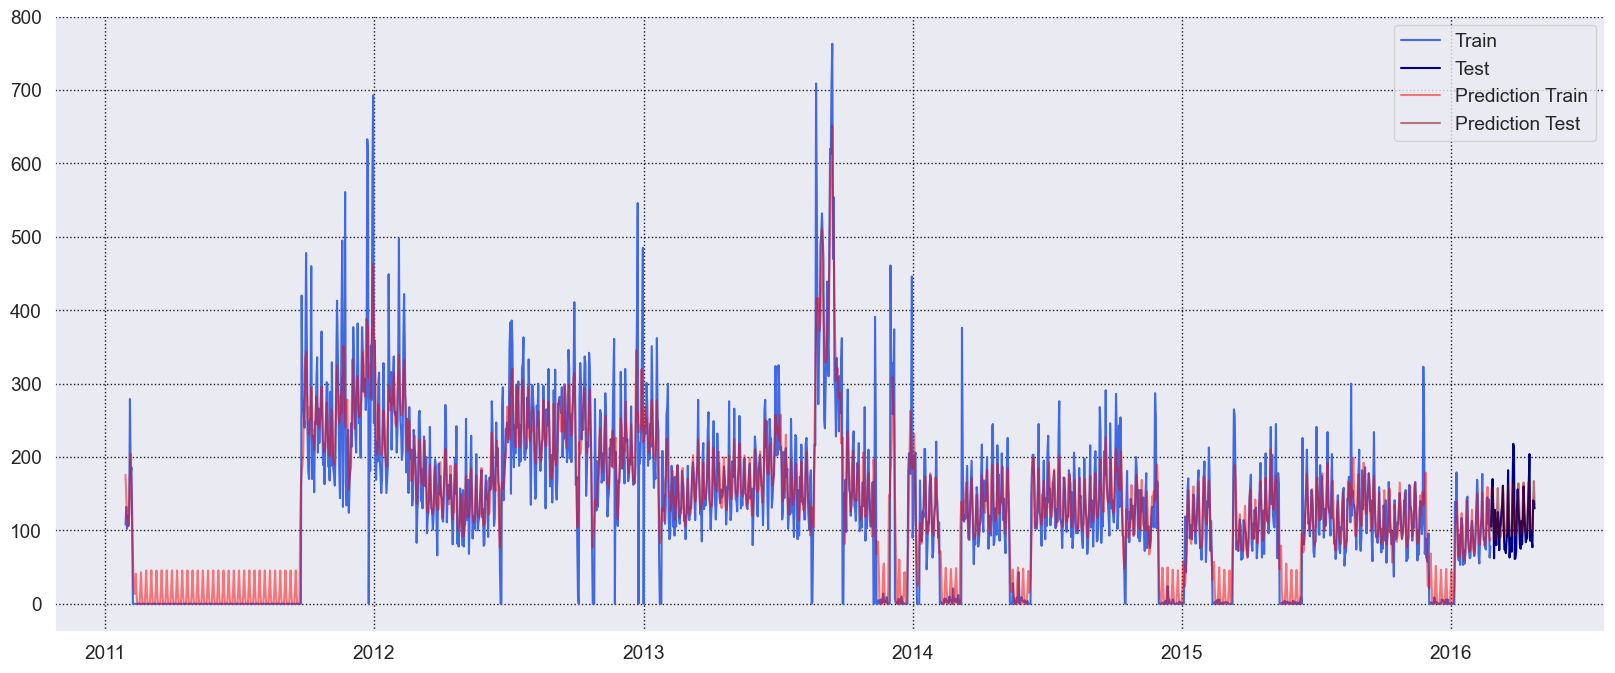

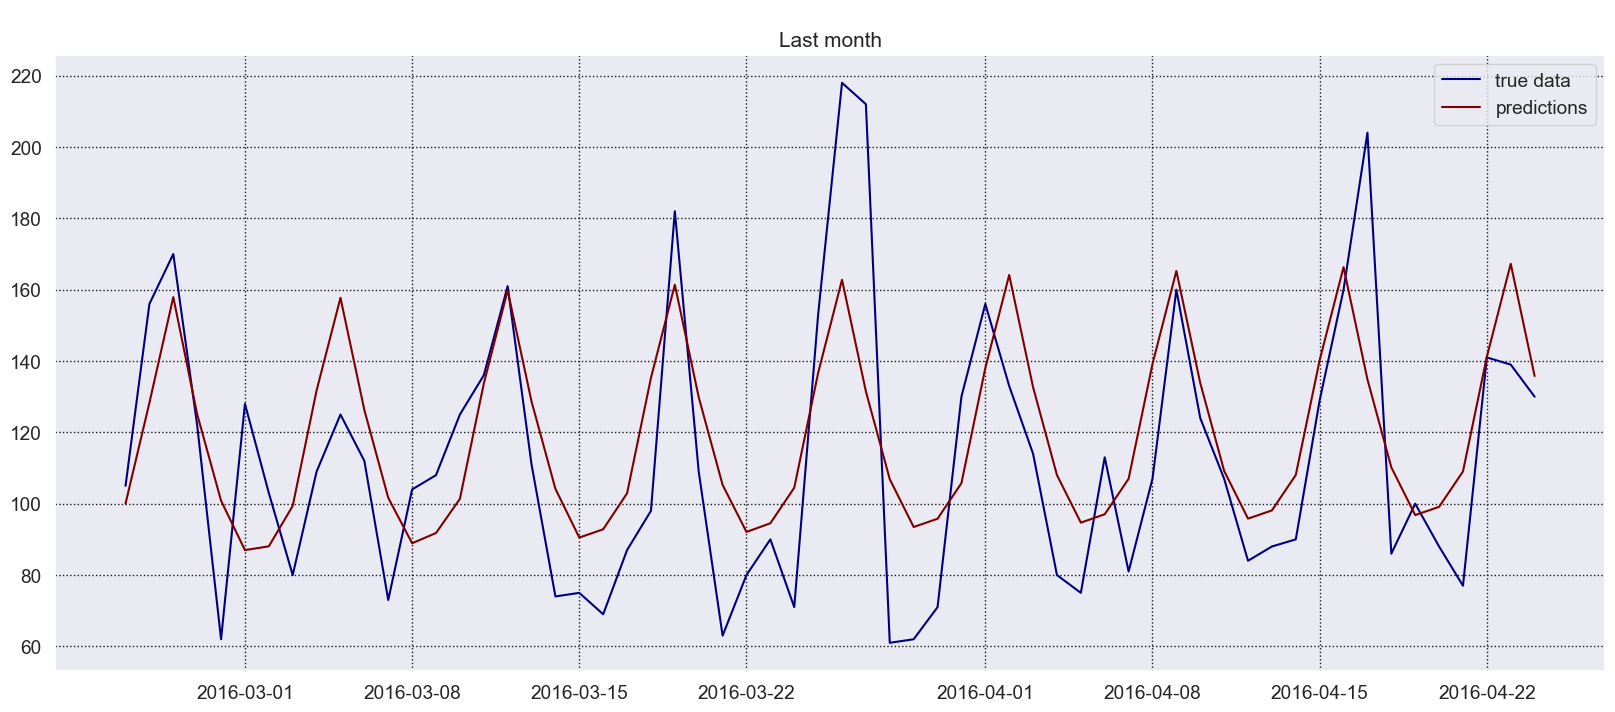

In [74]:
plot_prediction(train, test, true_col='FOODS_3_090_cnt', prediction_col='trend_seasonal_prediction')

In [135]:
pd.concat([arima_metrics_1, arima_metrics_2])

,TRAIN_MAE,TRAIN_MAPE %,TEST_MAE,TEST_MAPE %
ARIMA_7_0_7,37.547,100.571,26.864,27.966
ARIMA trend + seasonality,30.346,69.582,21.832,21.781


In [176]:
df= df.astype(float)

In [179]:
df.style.background_gradient(cmap=sns.color_palette("YlOrBr", as_cmap=True))

,TRAIN_MAE,TRAIN_MAPE %,TEST_MAE,TEST_MAPE %
ARIMA_7_0_7,37.547000,100.571000,26.864000,27.966000
ARIMA trend + seasonality,30.346000,69.582000,21.832000,21.781000
LSTM Regressor,95.870000,305.215000,92.200000,93.650000


## SARIMA

In [36]:
# import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

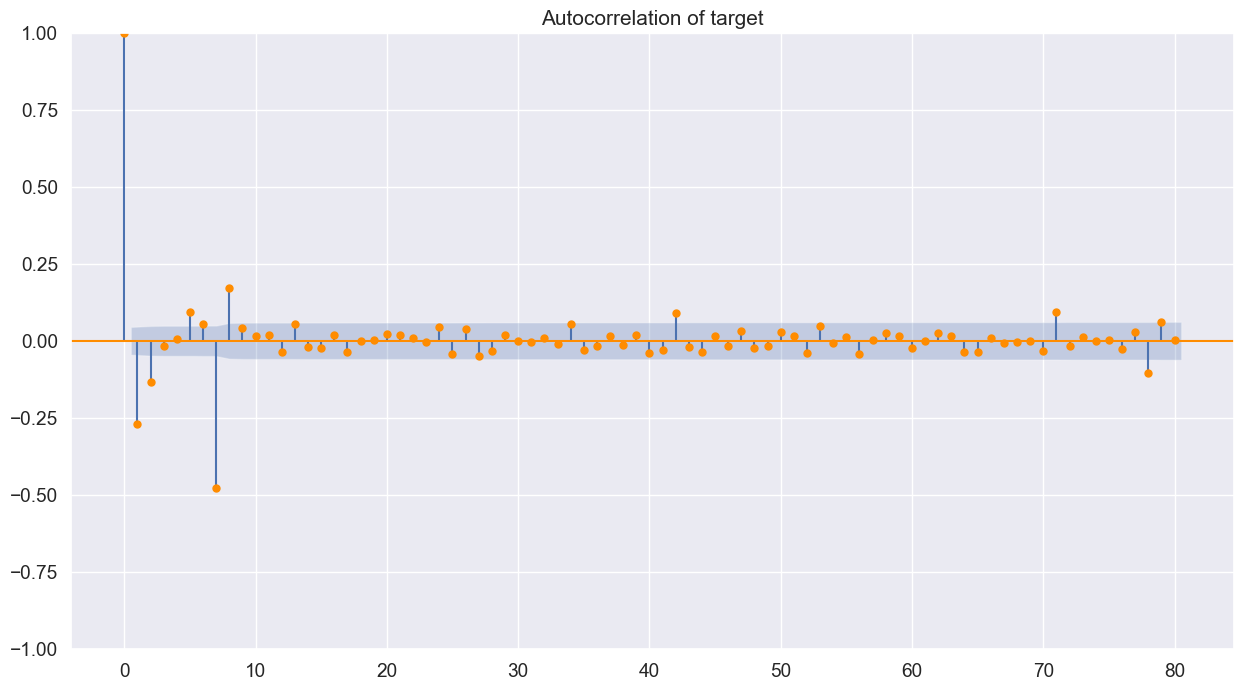

In [69]:
lags = 80

plot_acf(product_data['FOODS_3_090_cnt'].diff(periods=7).diff(periods=1).dropna(), lags=lags, color='darkorange', 
         title='Autocorrelation of target');

In [55]:
product_data= product_data.dropna()

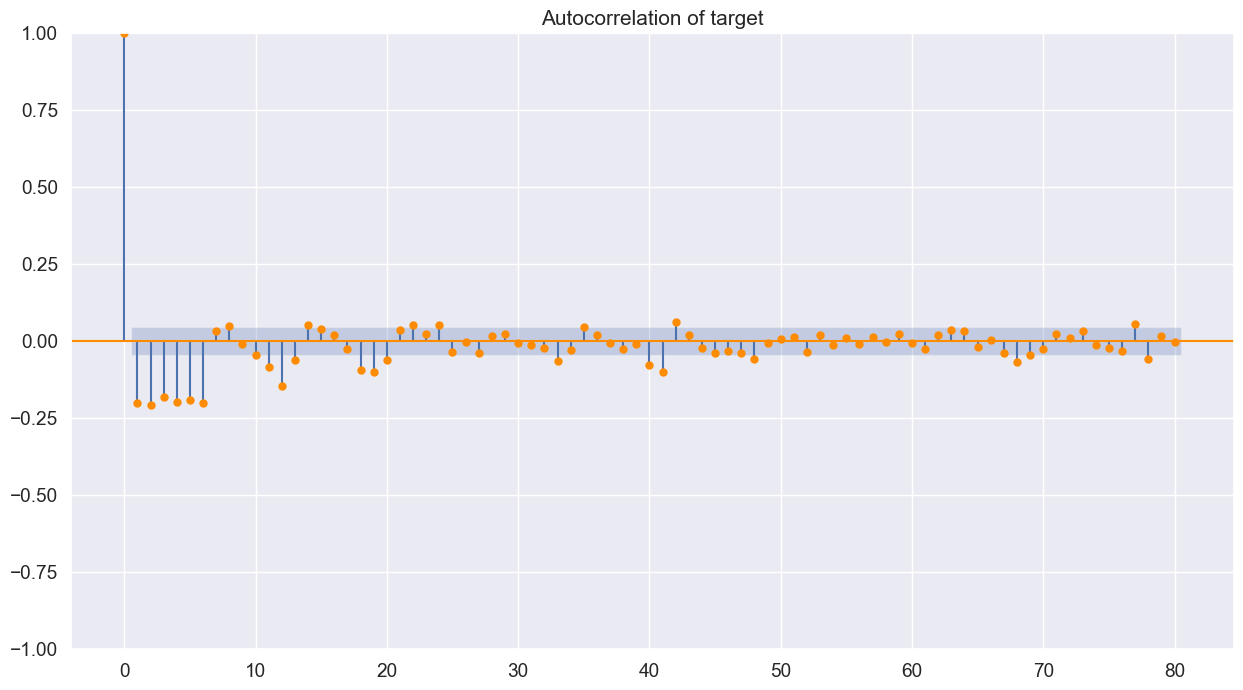

In [60]:
plot_pacf(product_data['FOODS_3_090_cnt'].diff(periods=1).dropna(), lags=lags, color='darkorange', 
         title='Autocorrelation of target');

In [150]:
model = SARIMAX(train['FOODS_3_090_cnt'], 
                order=(1, 0, 1), 
                seasonal_order=(10, 0, 5, 7))

In [70]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [71]:
check_stationarity(product_data['FOODS_3_090_cnt'])

The series is stationary


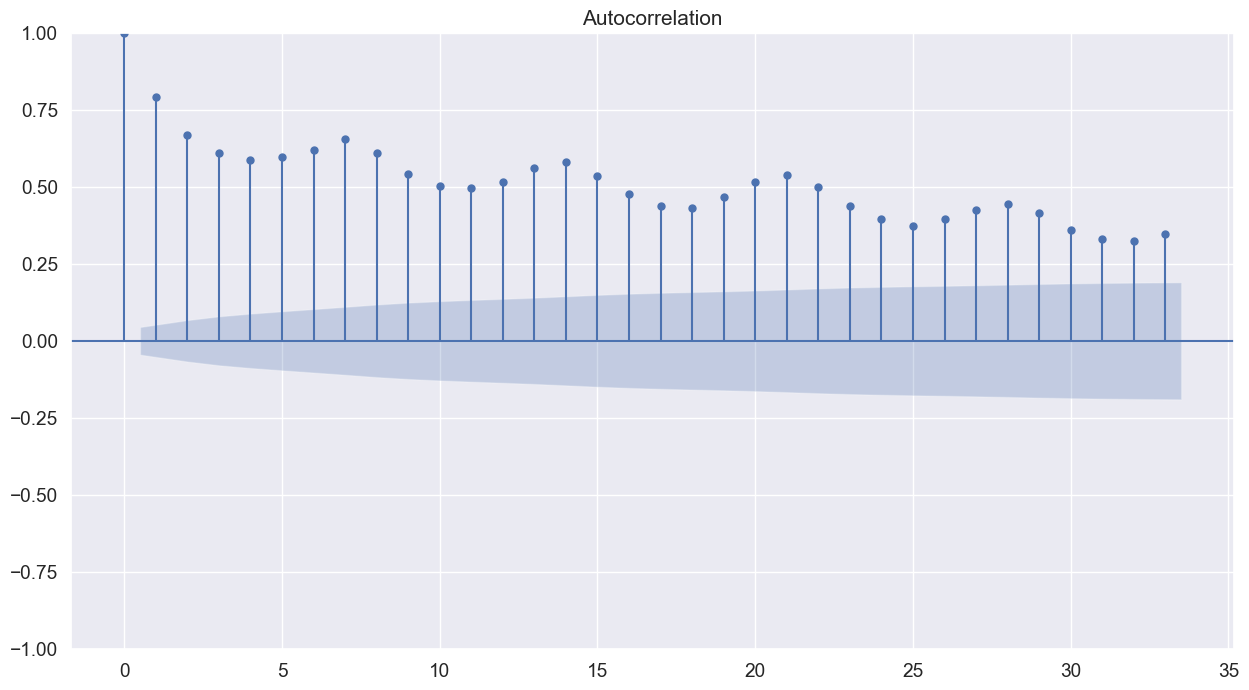

In [77]:
plot_acf(product_data['FOODS_3_090_cnt']);

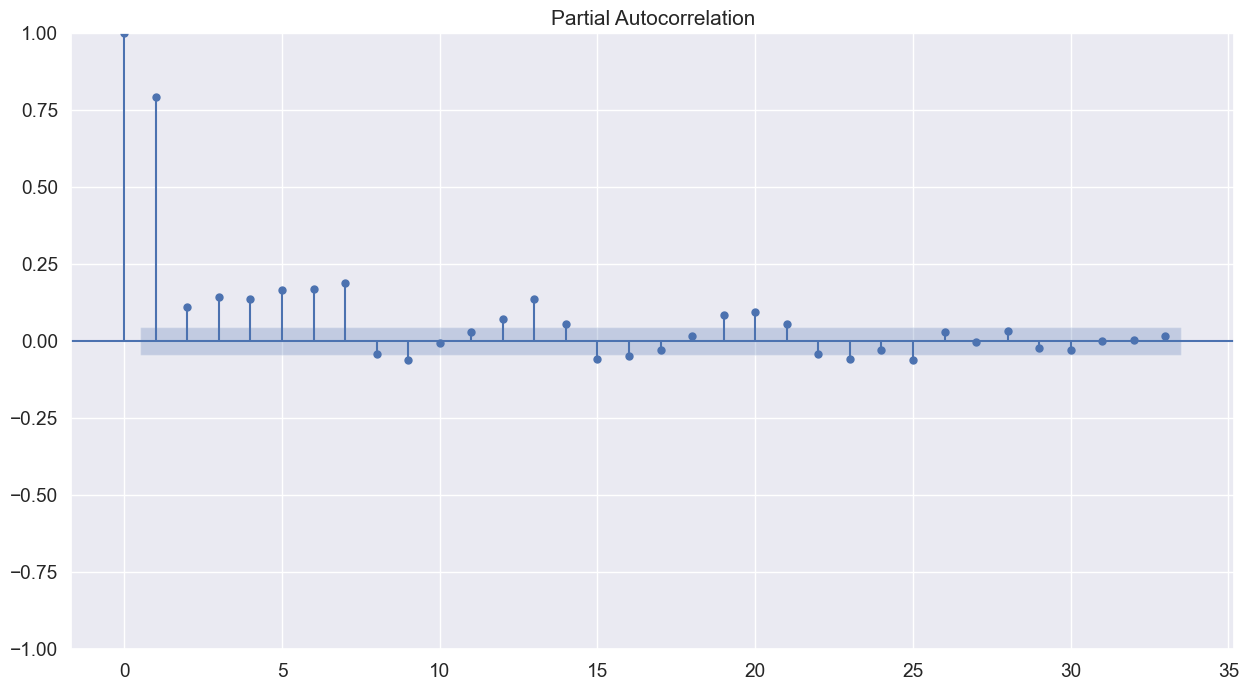

In [76]:
plot_pacf(product_data['FOODS_3_090_cnt']);

In [151]:
fitted_model = model.fit()

In [152]:
train['sarimax_prediction'] = fitted_model.predict(train.index[0], train.index[-1])
test['sarimax_prediction'] = fitted_model.predict(test.index[0], test.index[-1])

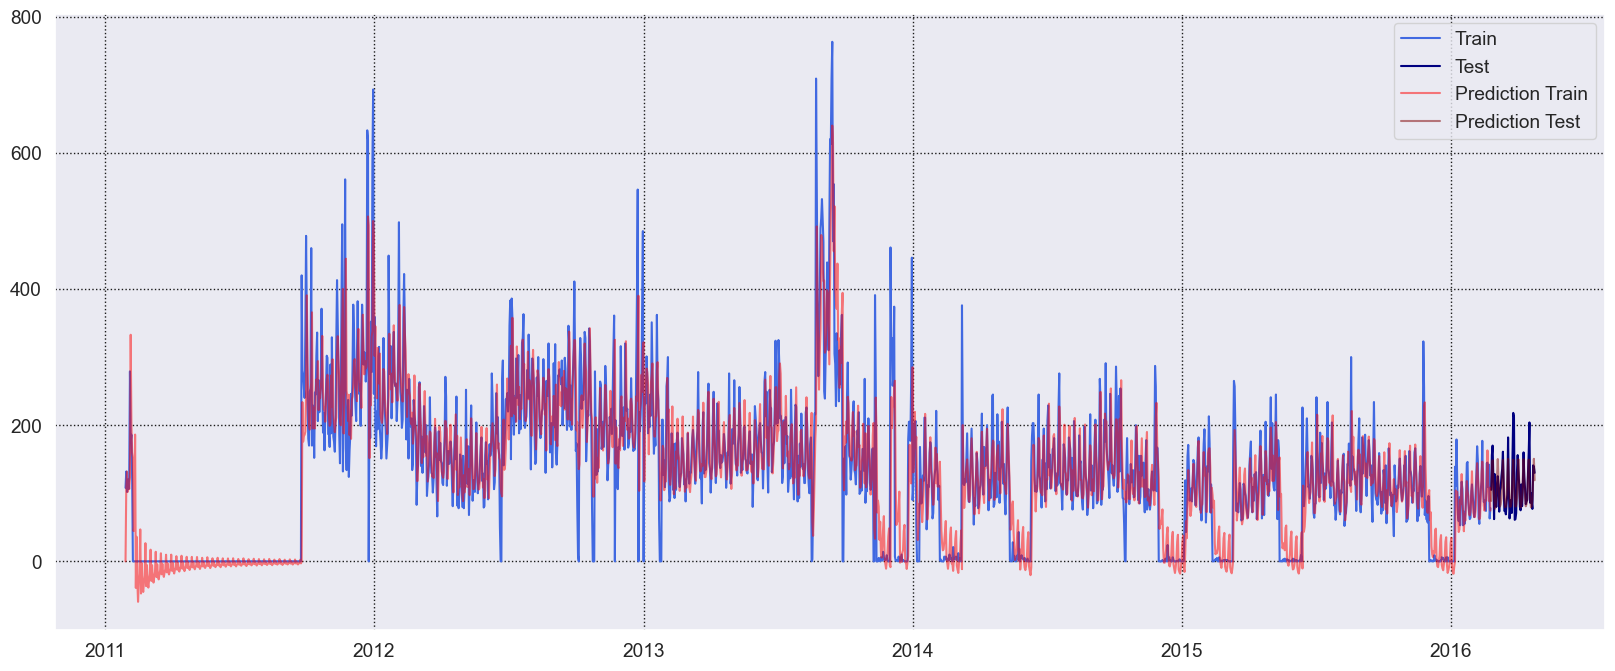

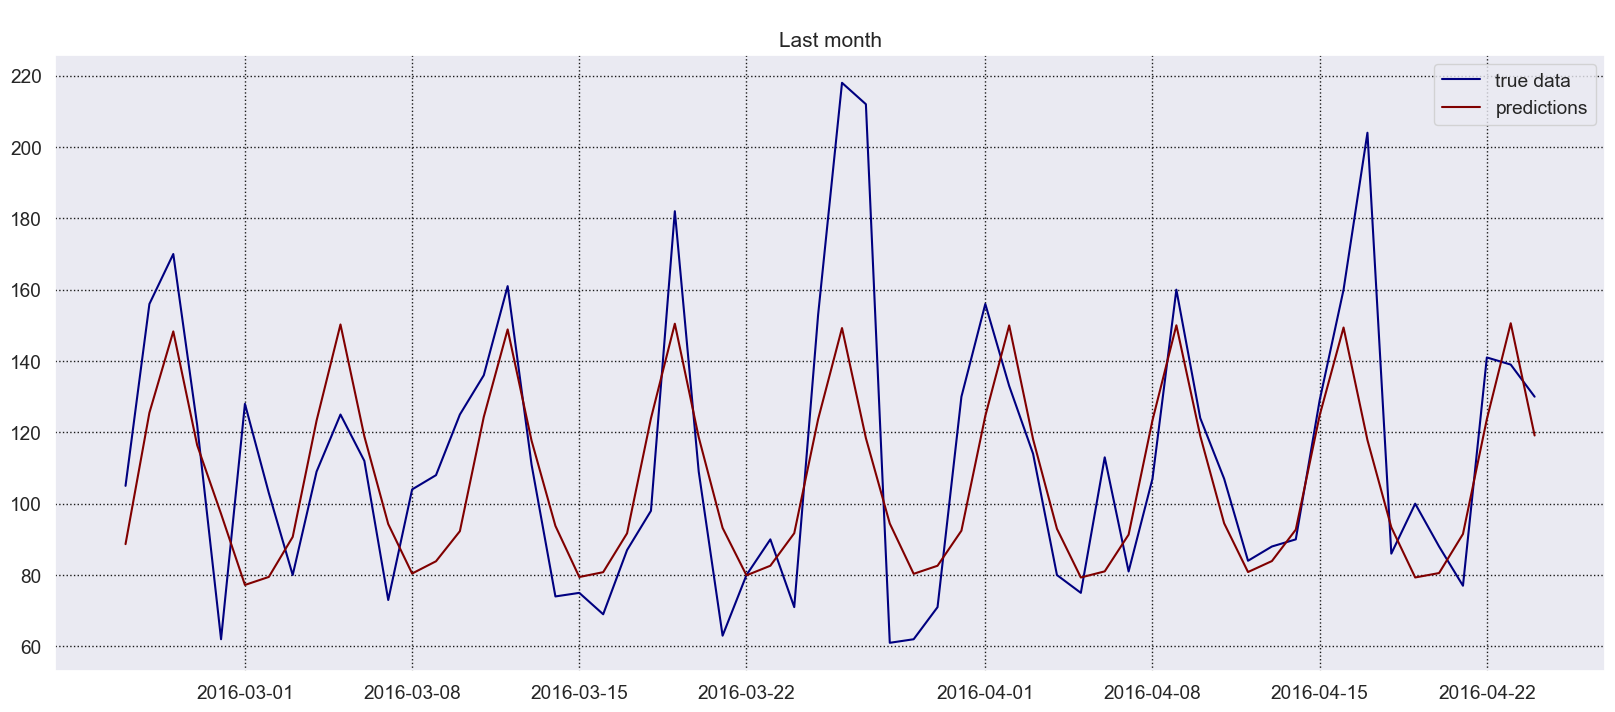

In [153]:
plot_prediction(train, test, true_col='FOODS_3_090_cnt', prediction_col='sarimax_prediction')

In [154]:
mean_absolute_error(train['FOODS_3_090_cnt'], train['sarimax_prediction']),\
mean_absolute_percentage_error(train['FOODS_3_090_cnt'], train['sarimax_prediction'])

(37.03163668179129, 2.3376027464104236e+16)

In [155]:
mean_absolute_error(test['FOODS_3_090_cnt'], test['sarimax_prediction']),\
mean_absolute_percentage_error(test['FOODS_3_090_cnt'], test['sarimax_prediction'])

(19.807902051735866, 0.17510417090494448)